In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
from PIL import Image
from tempfile import TemporaryDirectory

cudnn.benchmark = True
plt.ion() # interactive mode

In [4]:
# Data augmentation and normalisation for training
# Only normalisation for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'C:\\Users\\ZW\\Desktop\\NN&DL Tutorial\\hymenoptera_data\\hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train','val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train','val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

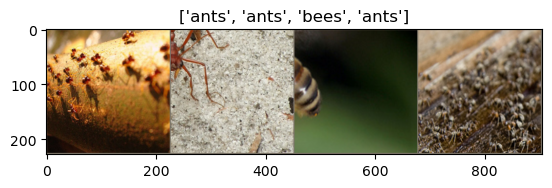

In [5]:
def imshow(inp, title=None):
  "Display image for Tensor"
  inp = inp.numpy().transpose((1,2,0))
  mean = np.array([0.485, 0.456, 0.406])
  std = np.array([0.229, 0.224, 0.225])
  inp = std * inp + mean
  inp = np.clip(inp, 0, 1)
  plt.imshow(inp)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)  # Pause to update the plots

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [6]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
  since = time.time()

  with TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

    torch.save(model.state_dict(), best_model_params_path)
    best_acc = 0.0

    for epoch in range(num_epochs):
      print(f"Epoch {epoch}/{num_epochs - 1}")
      print('-' * 10)

      # Each epoch has a training and validation phase
      for phase in ['train', 'val']:
        if phase == 'train':
          model.train() # Set model to training mode
        else:
          model.eval()  # Set model to evaluate mode

        running_loss = 0.0
        running_corrects = 0

        # Iterate over data
        for inputs, labels in dataloaders[phase]:
          inputs = inputs.to(device)
          labels = labels.to(device)

          # zero the parameter gradients
          optimizer.zero_grad()

          # forward
          # track history if only in train
          with torch.set_grad_enabled(phase == 'train'):
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

            # backward + optimize only if in training phase
            if phase == 'train':
              loss.backward()
              optimizer.step()

          # statistics
          running_loss += loss.item() * inputs.size(0)
          running_corrects += torch.sum(preds == labels.data)

        if phase == 'train':
          scheduler.step()

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

        # Deep copy the model
        if phase == 'val' and epoch_acc > best_acc:
          best_acc = epoch_acc
          torch.save(model.state_dict(), best_model_params_path)

      print()

    time_elapsed = time.time() - since

    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:.4f}')

    # load best model weights
    model.load_state_dict(torch.load(best_model_params_path))

  return model

In [7]:
def visualise_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [8]:
model_ft = models.resnet18(weights='IMAGENET1K_V1')
num_ftrs = model_ft.fc.in_features
# Size of each output sample here is set to 2

model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe all parameters are being optimised
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\ZW/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|█████████████████████████████████████████████████████████████████████████████| 44.7M/44.7M [00:01<00:00, 38.3MB/s]


In [9]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5518 Acc: 0.7254
val Loss: 0.2002 Acc: 0.9281

Epoch 1/24
----------
train Loss: 0.4990 Acc: 0.7746
val Loss: 0.2752 Acc: 0.8758

Epoch 2/24
----------
train Loss: 0.5300 Acc: 0.7828
val Loss: 0.2243 Acc: 0.9281

Epoch 3/24
----------
train Loss: 0.3633 Acc: 0.8402
val Loss: 0.3309 Acc: 0.8954

Epoch 4/24
----------
train Loss: 0.3639 Acc: 0.8156
val Loss: 0.2973 Acc: 0.9085

Epoch 5/24
----------
train Loss: 0.3602 Acc: 0.8443
val Loss: 0.5450 Acc: 0.8431

Epoch 6/24
----------
train Loss: 0.4901 Acc: 0.7910
val Loss: 0.3020 Acc: 0.8954

Epoch 7/24
----------
train Loss: 0.3784 Acc: 0.8402
val Loss: 0.2985 Acc: 0.8954

Epoch 8/24
----------
train Loss: 0.3124 Acc: 0.8852
val Loss: 0.2983 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.4083 Acc: 0.8525
val Loss: 0.2073 Acc: 0.9150

Epoch 10/24
----------
train Loss: 0.2524 Acc: 0.8934
val Loss: 0.2444 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.1744 Acc: 0.9344
val Loss: 0.2497 Acc: 0.9150

Ep

C:\Users\ZW\AppData\Local\Temp\ipykernel_5384\1912199843.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


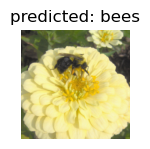

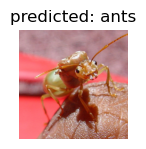

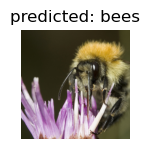

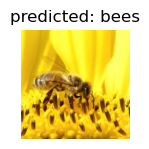

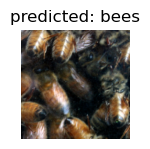

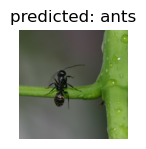

In [10]:
visualise_model(model_ft)

In [11]:
model_conv = torchvision.models.resnet18(weights='IMAGENET1K_V1')
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Only parameters of the final layer are being optimised as compared to above
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

In [12]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.5703 Acc: 0.7090
val Loss: 0.2222 Acc: 0.9412

Epoch 1/24
----------
train Loss: 0.4696 Acc: 0.7500
val Loss: 0.5805 Acc: 0.7778

Epoch 2/24
----------
train Loss: 0.5116 Acc: 0.7869
val Loss: 0.1948 Acc: 0.9216

Epoch 3/24
----------
train Loss: 0.3409 Acc: 0.8361
val Loss: 0.1431 Acc: 0.9542

Epoch 4/24
----------
train Loss: 0.4253 Acc: 0.8361
val Loss: 0.1459 Acc: 0.9542

Epoch 5/24
----------
train Loss: 0.5460 Acc: 0.7910
val Loss: 0.1651 Acc: 0.9542

Epoch 6/24
----------
train Loss: 0.3890 Acc: 0.8320
val Loss: 0.1584 Acc: 0.9542

Epoch 7/24
----------
train Loss: 0.3489 Acc: 0.8607
val Loss: 0.1792 Acc: 0.9542

Epoch 8/24
----------
train Loss: 0.3085 Acc: 0.8689
val Loss: 0.1632 Acc: 0.9542

Epoch 9/24
----------
train Loss: 0.3342 Acc: 0.8730
val Loss: 0.1544 Acc: 0.9542

Epoch 10/24
----------
train Loss: 0.2926 Acc: 0.8770
val Loss: 0.1611 Acc: 0.9542

Epoch 11/24
----------
train Loss: 0.3603 Acc: 0.8566
val Loss: 0.1536 Acc: 0.9673

Ep

C:\Users\ZW\AppData\Local\Temp\ipykernel_5384\1912199843.py:69: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(best_model_params_path))


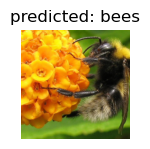

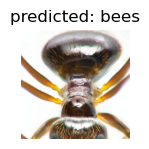

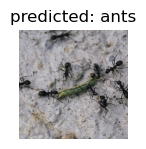

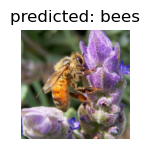

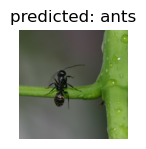

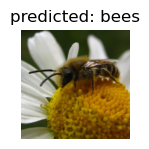

In [13]:
visualise_model(model_conv)

plt.ioff()
plt.show()

In [14]:
def visualise_model_predictions(model, img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

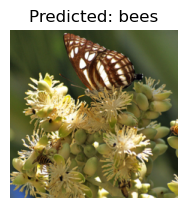

In [16]:
visualise_model_predictions(
    model_conv,
    img_path='C:\\Users\\ZW\\Desktop\\NN&DL Tutorial\\hymenoptera_data\\hymenoptera_data\\val\\bees\\72100438_73de9f17af.jpg'
)

plt.ioff()
plt.show()